In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import napari
from glob import glob
from tifffile import imread
from csbdeep.utils import Path
from csbdeep.io import save_tiff_imagej_compatible

from skimage import measure
from skimage.transform import resize
import pandas as pd
sys.path.append(os.path.abspath(".."))  
from utils.MergeLabels import MergeLabels
from utils.SplitLabels import SplitLabels
from utils.ImagingFunctions import subtract_background
from utils.RemoveRegion import remove_region
from utils.SplitLabelsPoints import SplitLabelsPoints

In [2]:
import sys
print(sys.path)

['/home/el_tito/anaconda3/envs/ImgAnUbun/lib/python310.zip', '/home/el_tito/anaconda3/envs/ImgAnUbun/lib/python3.10', '/home/el_tito/anaconda3/envs/ImgAnUbun/lib/python3.10/lib-dynload', '', '/home/el_tito/anaconda3/envs/ImgAnUbun/lib/python3.10/site-packages', '/home/el_tito/anaconda3/envs/ImageAnalysis/Code']


Found 18 image files.


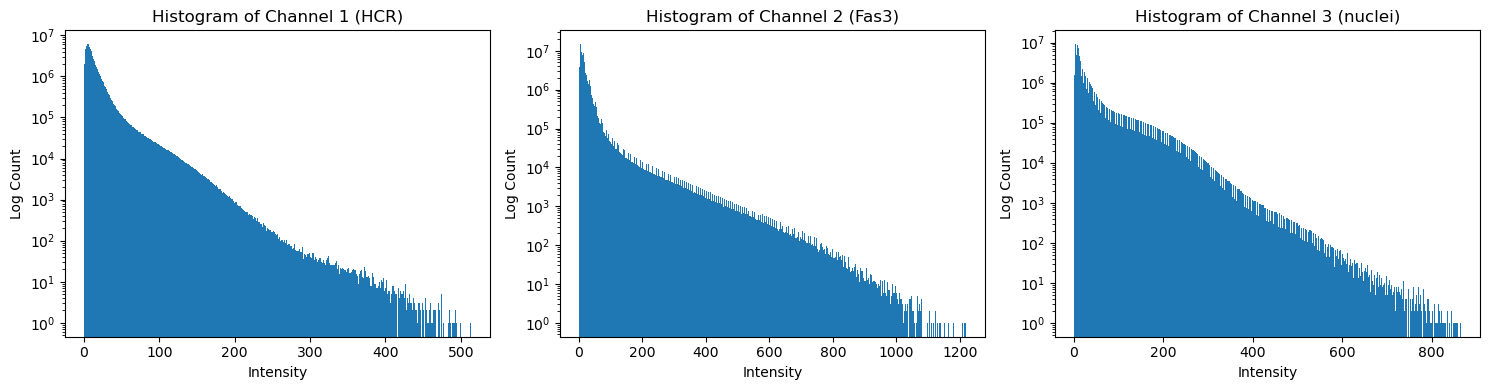

In [3]:
# Set up paths
data_directory = Path('/media/el_tito/T7 Shield/20250605 histone compass/tiffed30z/h3k4me2/current/')
label_directory = Path('/media/el_tito/T7 Shield/20250605 histone compass/masks/h3k4me2/')
results_directory = Path('/media/el_tito/T7 Shield/20250605 histone compass/edited masks/h3k4me2/')
os.makedirs(results_directory, exist_ok=True)

# Get list of image files
filelist = sorted(glob(os.path.join(data_directory, "*.tif*")))
print(f"Found {len(filelist)} image files.")

# Function to plot histograms from the first image
def plot_histogram(image_path):
    img = imread(image_path)  # shape: (Z, C, Y, X)
    img = np.moveaxis(img, 1, -1)  # to (Z, Y, X, C)

    plt.figure(figsize=(15, 4))
    for i, channel_name in enumerate(["HCR", "Fas3", "nuclei"]):
        plt.subplot(1, 3, i+1)
        plt.hist(img[..., i].ravel(), bins=512, log=True)
        plt.title(f"Histogram of Channel {i+1} ({channel_name})")
        plt.xlabel("Intensity")
        plt.ylabel("Log Count")
    plt.tight_layout()
    plt.show()
plot_histogram(filelist[0])

In [4]:
def launch_viewer(img, labels_upscaled, basename, n_labels_before):
    viewer = napari.Viewer()
    viewer.add_image(
        img[..., :3], channel_axis=3,
        name=["HCR", "Fas3", "nuclei"],
        colormap=["grey","magenta","cyan"],
        contrast_limits=[[0,300],[0,1100],[0,400]],
        blending='additive'
    )
    viewer.add_labels(labels_upscaled, name='labels_shifted', blending='additive')

    def on_close(event=None):
        edited = viewer.layers["labels_shifted"].data.astype(np.uint16)
        n_after = (np.unique(edited) > 0).sum()
        print(f"After: {n_after} labels (Δ {n_after - n_labels_before})")

        outname = os.path.splitext(basename)[0]
        save_tiff_imagej_compatible(results_directory / f"{outname}_edited.tif", edited, axes="ZYX")
        # removed saving image properties (props CSV)
        print("Saved edits.\n")

    orig = viewer.window._qt_window.closeEvent
    def wrapped(event):
        on_close(event); orig(event)
    viewer.window._qt_window.closeEvent = wrapped

    viewer.show(block=True)  # <-- critical: blocks loop until closed
    print("Viewer closed, moving to next image.")

def process_image(img_path):
    basename = os.path.basename(img_path)
    img = imread(img_path)
    img = np.moveaxis(img, 1, -1)
    labels_path = os.path.join(label_directory, basename)
    if not os.path.exists(labels_path):
        print(f"Missing {basename}, skipping.")
        return
    raw = imread(labels_path).astype(np.uint16)
    labels_up = resize(raw, output_shape=img.shape[:3], order=0,
                       preserve_range=True, anti_aliasing=False).astype(np.uint16)
    n_before = (np.unique(labels_up) > 0).sum()
    print(f"\n--- {basename}: {n_before} labels before editing")
    launch_viewer(img, labels_up, basename, n_before)

if __name__ == "__main__":
    for path in filelist:
        process_image(path)



--- 20250605 c22_001.tiff: 33 labels before editing
After: 34 labels (Δ 1)
Saved edits.

Viewer closed, moving to next image.

--- 20250605 c22_002.tiff: 40 labels before editing
After: 41 labels (Δ 1)
Saved edits.

Viewer closed, moving to next image.

--- 20250605 c22_003.tiff: 63 labels before editing
After: 64 labels (Δ 1)
Saved edits.

Viewer closed, moving to next image.

--- 20250605 c22_004.tiff: 57 labels before editing
INFO: Current selected label is not being used. You will need to use it first to be able to set the current select label to the next one available
After: 58 labels (Δ 1)
Saved edits.

Viewer closed, moving to next image.

--- 20250605 c22_005.tiff: 22 labels before editing
After: 23 labels (Δ 1)
Saved edits.

Viewer closed, moving to next image.

--- 20250605 c22_006.tiff: 32 labels before editing
After: 33 labels (Δ 1)
Saved edits.

Viewer closed, moving to next image.

--- 20250605 c22_007.tiff: 21 labels before editing
After: 22 labels (Δ 1)
Saved edits.

V